# BERT-based Sentiment Classification on IMDB Movie Reviews

This notebook implements:
1. Data loading and preprocessing
2. BERT model and tokenizer loading from Hugging Face
3. Fine-tuning BERT for binary sentiment classification
4. Evaluation metrics (Accuracy, Precision, Recall, F1-score)


In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, AutoTokenizer
import warnings
import re

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPU available: []


## 1. Data Preparation

### 1.1 Load IMDB Dataset


In [16]:
# Load the IMDB dataset
df = pd.read_csv('IMDB Dataset.csv')

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1.2 Text Preprocessing


In [17]:
def clean_text(text):
    """
    Clean text by removing HTML tags and extra whitespace
    """
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Clean the reviews
df['review'] = df['review'].apply(clean_text)

# Encode sentiment labels: positive -> 1, negative -> 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df.head()


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### 1.3 Train/Test Split


In [18]:
# Split into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['review'].values,
    df['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=df['label']
)

# Split temp into validation and test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(test_texts)}")
print(f"\nTraining label distribution:")
print(pd.Series(train_labels).value_counts().sort_index())
print(f"\nValidation label distribution:")
print(pd.Series(val_labels).value_counts().sort_index())
print(f"\nTest label distribution:")
print(pd.Series(test_labels).value_counts().sort_index())


Training set size: 35000
Validation set size: 7500
Test set size: 7500

Training label distribution:
0    17500
1    17500
Name: count, dtype: int64

Validation label distribution:
0    3750
1    3750
Name: count, dtype: int64

Test label distribution:
0    3750
1    3750
Name: count, dtype: int64


## 2. Load Pre-trained BERT Tokenizer


In [19]:
# Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## 3. Apply BERT Tokenization


In [20]:
max_len = 128  # Maximum sequence length

# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(
    train_texts.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

X_val_encoded = tokenizer.batch_encode_plus(
    val_texts.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

X_test_encoded = tokenizer.batch_encode_plus(
    test_texts.tolist(),
    padding=True,
    truncation=True,
    max_length=max_len,
    return_tensors='tf'
)

print(f"Training samples: {len(X_train_encoded['input_ids'])}")
print(f"Validation samples: {len(X_val_encoded['input_ids'])}")
print(f"Test samples: {len(X_test_encoded['input_ids'])}")


Training samples: 35000
Validation samples: 7500
Test samples: 7500


### 3.1 Check the Encoded Dataset


In [21]:
# Check the encoded dataset
k = 0
print('Training Comment: ', train_texts[k])
print('\nInput Ids:\n', X_train_encoded['input_ids'][k])
print('\nDecoded Ids:\n', tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask:\n', X_train_encoded['attention_mask'][k])
print('\nLabels: ', train_labels[k])


Training Comment:  If you want to see a true thriller, rent this!!! It's not from the director or screenwriter of "Scream", doesn't feature overacting, overpaid "TV" actors passing off as "stars", and is not a run of the mill special effects bonanza. Instead you'll get a top-notch, edgy, very strong (in violence) yet thrilling nailbiter.

Input Ids:
 tf.Tensor(
[  101  2065  2017  2215  2000  2156  1037  2995 10874  1010  9278  2023
   999   999   999  2009  1005  1055  2025  2013  1996  2472  2030 11167
  1997  1000  6978  1000  1010  2987  1005  1056  3444  2058 18908  2075
  1010  2058  4502  3593  1000  2694  1000  5889  4458  2125  2004  1000
  3340  1000  1010  1998  2003  2025  1037  2448  1997  1996  4971  2569
  3896 14753 16076  1012  2612  2017  1005  2222  2131  1037  2327  1011
 18624  1010  3968  6292  1010  2200  2844  1006  1999  4808  1007  2664
 26162 13774 16313  2121  1012   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0    

## 4. Load the Model


In [22]:
# Initialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, use_safetensors=False)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5. Compile the Model


In [23]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


## 6. Train the Model


In [24]:
history = model.fit(
    [X_train_encoded['input_ids'][:7000], X_train_encoded['token_type_ids'][:7000], X_train_encoded['attention_mask'][:7000]],
    train_labels[:7000],
    validation_data=(
        [X_val_encoded['input_ids'][:5000], X_val_encoded['token_type_ids'][:5000], X_val_encoded['attention_mask'][:5000]],
        val_labels[:5000]
    ),
    batch_size=32,
    epochs=3
)


Epoch 1/3
219/219 [==============================] - 5336s 24s/step - loss: 0.4179 - accuracy: 0.8061 - val_loss: 0.3479 - val_accuracy: 0.8528
Epoch 2/3
219/219 [==============================] - 3571s 16s/step - loss: 0.2282 - accuracy: 0.9103 - val_loss: 0.3184 - val_accuracy: 0.8698
Epoch 3/3
219/219 [==============================] - 3491s 16s/step - loss: 0.1241 - accuracy: 0.9576 - val_loss: 0.3988 - val_accuracy: 0.8684


## 7. Evaluate the Model on Test Set


In [25]:
# Evaluate on test set
test_results = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    test_labels,
    batch_size=32,
    verbose=1
)

print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Get predictions
predictions = model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    batch_size=32
)

test_predictions = np.argmax(predictions.logits, axis=1)

# Calculate detailed metrics
accuracy = accuracy_score(test_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_predictions, average='binary'
)

print(f"\nDetailed Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Negative', 'Positive']))


235/235 [==============================] - 1904s 8s/step - loss: 0.4027 - accuracy: 0.8637

Test Loss: 0.4027
Test Accuracy: 0.8637
235/235 [==============================] - 1266s 5s/step

Detailed Metrics:
  Accuracy:  0.8637
  Precision: 0.8420
  Recall:    0.8955
  F1-Score:  0.8679

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86      3750
    Positive       0.84      0.90      0.87      3750

    accuracy                           0.86      7500
   macro avg       0.87      0.86      0.86      7500
weighted avg       0.87      0.86      0.86      7500



## 8. Visualize Training History


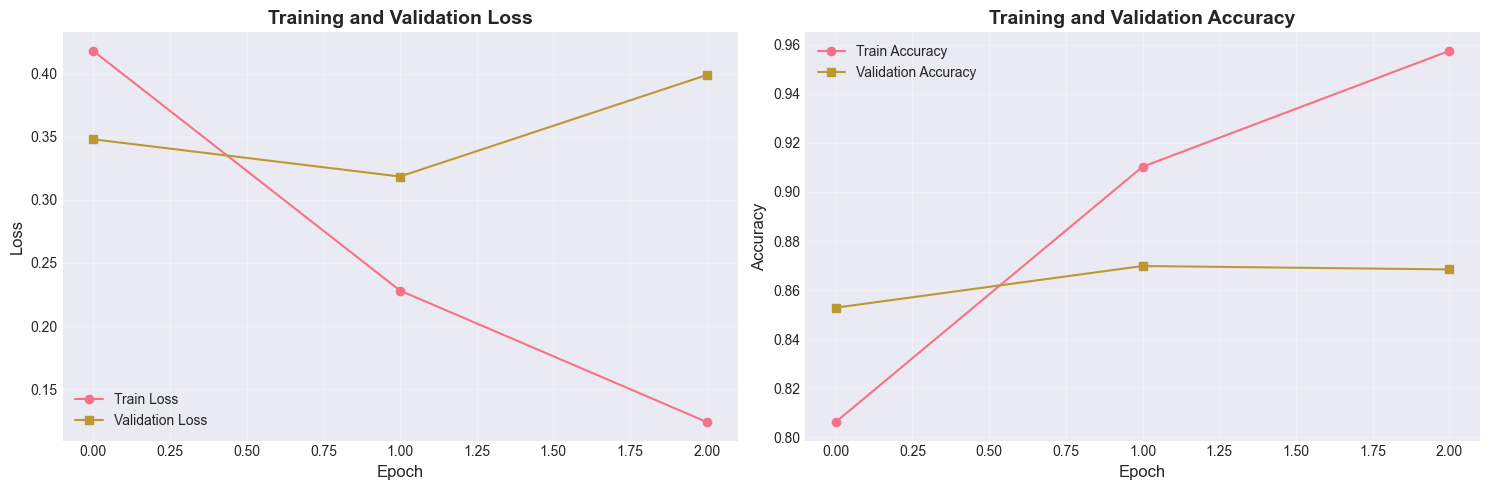

In [26]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Confusion Matrix


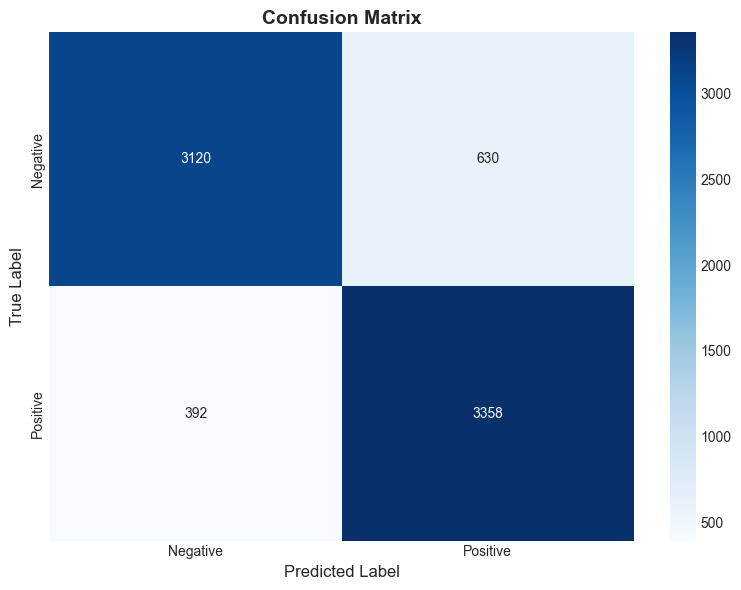


Confusion Matrix:
[[3120  630]
 [ 392 3358]]


In [27]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'],
    ax=ax
)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)


## 10. Manual Inspection of Examples


In [28]:
# Function to predict sentiment for a single review
def predict_sentiment(text, model, tokenizer):
    """
    Predict sentiment for a single text
    """
    # Tokenize
    encoding = tokenizer.batch_encode_plus(
        [text],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    
    # Predict
    predictions = model.predict([
        encoding['input_ids'],
        encoding['token_type_ids'],
        encoding['attention_mask']
    ])
    
    probabilities = tf.nn.softmax(predictions.logits, axis=1)
    prediction = np.argmax(probabilities, axis=1)[0]
    
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    confidence = probabilities[0][prediction].numpy()
    
    return sentiment, confidence

# Test on some examples
print("Manual Inspection of Examples")

# Get some test examples
test_indices = [0, 1, 2, 3, 4]
for idx in test_indices:
    text = test_texts[idx]
    true_label = 'Positive' if test_labels[idx] == 1 else 'Negative'
    pred_sentiment, confidence = predict_sentiment(text, model, tokenizer)
    
    print(f"\nExample {idx + 1}:")
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred_sentiment} (confidence: {confidence:.4f})")
    print(f"Review (first 200 chars): {text[:200]}...")
    print(f"Match: {'✓' if (true_label == pred_sentiment) else '✗'}")

# Test on clearly positive and negative examples
print("Testing on Clearly Positive and Negative Reviews")

clearly_positive = "This movie is absolutely fantastic! I loved every minute of it. The acting was superb, the plot was engaging, and the cinematography was breathtaking. Highly recommended!"
clearly_negative = "This is the worst movie I have ever seen. Terrible acting, boring plot, and poor direction. I would not recommend this to anyone. Complete waste of time."

for label, text in [("Clearly Positive", clearly_positive), ("Clearly Negative", clearly_negative)]:
    pred_sentiment, confidence = predict_sentiment(text, model, tokenizer)
    print(f"\n{label} Review:")
    print(f"Text: {text}")
    print(f"Predicted: {pred_sentiment} (confidence: {confidence:.4f})")
    print(f"Correct: {'✓' if (label == 'Clearly Positive' and pred_sentiment == 'Positive') or (label == 'Clearly Negative' and pred_sentiment == 'Negative') else '✗'}")


Manual Inspection of Examples
1/1 [==============================] - 1s 575ms/step

Example 1:
True Label: Negative
Predicted: Negative (confidence: 0.7136)
Review (first 200 chars): My parents used to rent a lot of horror movies when I was a child. We loved watching them even when they were bad they made for some enjoyment. This was one such movie, kind of hard to review as I hav...
Match: ✓
1/1 [==============================] - 0s 338ms/step

Example 2:
True Label: Positive
Predicted: Positive (confidence: 0.9938)
Review (first 200 chars): I got a chance to see this movie at an early screening in Brea and I have been crazy for it ever since. The film is based on Shakespeare's Twelfth Night which I have read and loved and seen on stage a...
Match: ✓
1/1 [==============================] - 0s 325ms/step

Example 3:
True Label: Negative
Predicted: Negative (confidence: 0.9977)
Review (first 200 chars): Well the previews looked funny and I usually don't go to movies on opening night espe

## 11. Inference Time Test


In [29]:
import time

# Test inference time
test_review = "This movie is absolutely fantastic! I loved every minute of it."
num_tests = 100

print(f"Testing inference time on {num_tests} predictions...")
start_time = time.time()

for _ in range(num_tests):
    _ = predict_sentiment(test_review, model, tokenizer)

end_time = time.time()
total_time = end_time - start_time
avg_time = total_time / num_tests

print(f"\nInference Time Results:")
print(f"  Total time for {num_tests} predictions: {total_time:.4f} seconds")
print(f"  Average time per prediction: {avg_time:.4f} seconds ({avg_time*1000:.2f} ms)")
print(f"  Predictions per second: {1/avg_time:.2f}")

if avg_time < 1.0:
    print(f"\nInference time is suitable for practical use (< 1 second per review)")
else:
    print(f"\nInference time may be slow for real-time applications")


Testing inference time on 100 predictions...
1/1 [==============================] - 0s 128ms/step

Inference Time Results:
  Total time for 100 predictions: 27.1002 seconds
  Average time per prediction: 0.2710 seconds (271.00 ms)
  Predictions per second: 3.69

Inference time is suitable for practical use (< 1 second per review)
